# Miniproject 1 - Variant 3 #

In [1]:
# duh
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal # For signal generation + convolution
from scipy.stats import gamma # For Gamma function
import pandas as pd # generate design matrix
from nilearn.plotting import plot_design_matrix # plot design matrix

%matplotlib notebook

## 1. Generation of the Stimulus Signal ##

We imaging to show the stimuli to the subject as described in the assignment paper. Assume a linear activation of neurons with the presentation of the stimuli, thus, the signal created below is assumed to correspond to the actual activation of the neurons. 

*Should we consider controls?*

*"Each individual presentation lasting 2 seconds": does that mean Diracs 2 seconds apart?*

The function simulates a voxel response when an individual is shown a repeating series of images of faces for two seconds (where the amplitude is 1) followed by non-facial control images for eight seconds (where there is no amplitude).

<IPython.core.display.Javascript object>


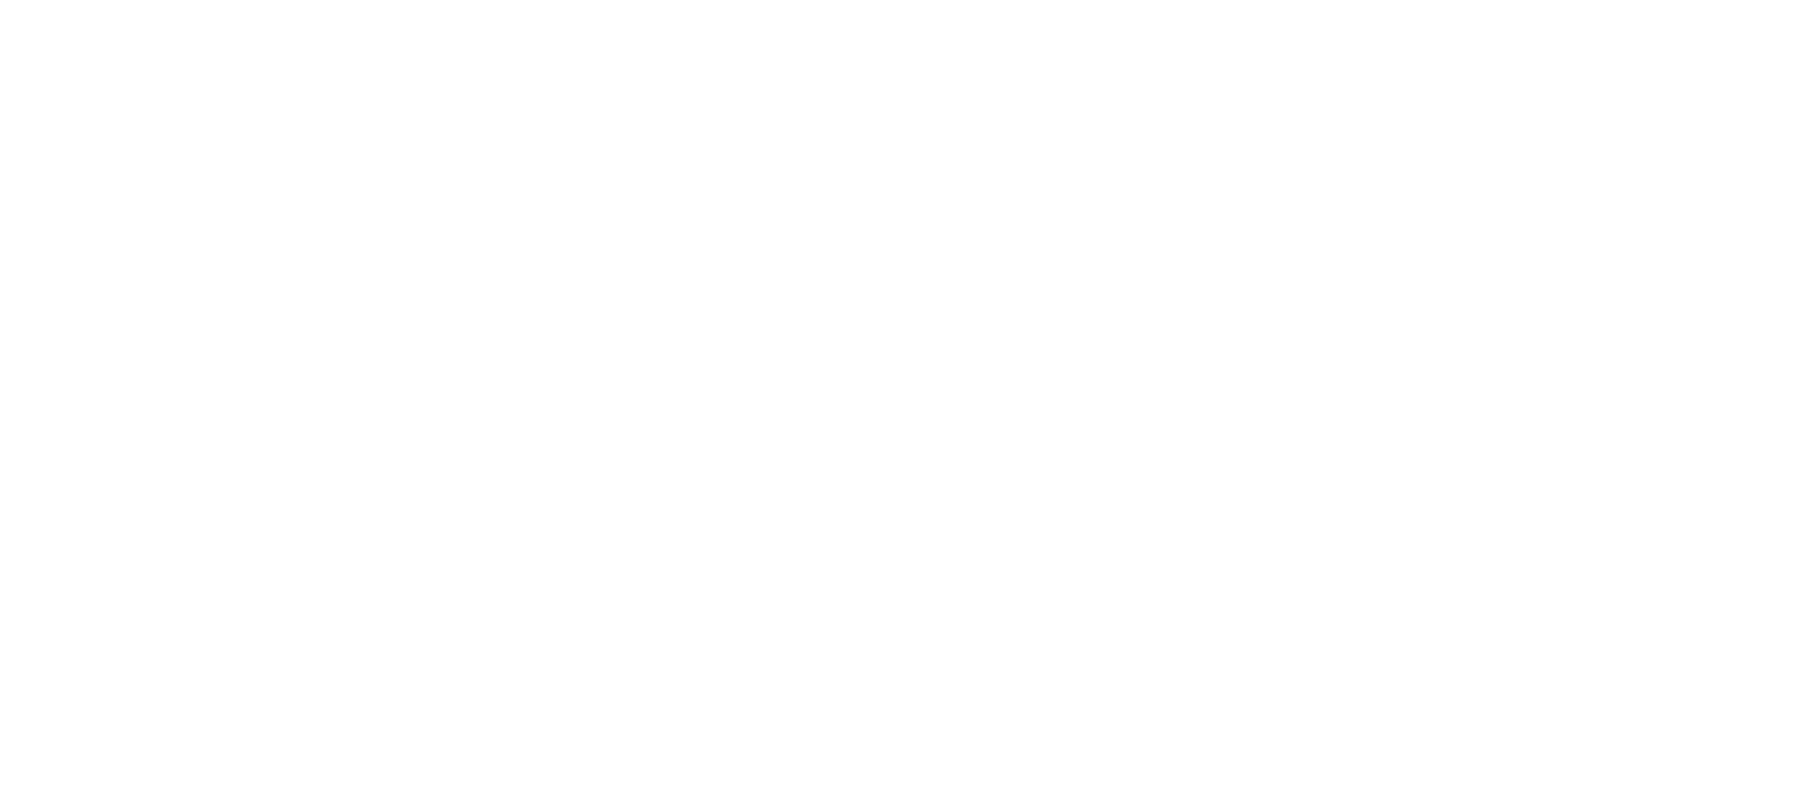

Text(0, 0.5, 'activation')

In [2]:
Ts = 10 # 1 / sampling frequency [Hz]
total_duration = 100 # [sec]
t = np.arange(0, total_duration, 1/Ts)
presentation_duration = 2 # [s]
episode_duration = 10 # [s] one stimulus + one rest (control)
neur = 0.5*(scipy.signal.square(2*np.pi*(1/episode_duration)*t, presentation_duration/episode_duration)+1)

plt.figure(figsize=(9,4))
plt.plot(t, neur)
plt.title('Single voxel time series')
plt.xlabel('time (seconds)')
plt.ylabel('activation')

## 2. Generation of the HRF Response Function ##

We now consider the response of the blood-oxygen level (BOLD) signal.

Consider an impulse (ie Dirac impulse) activation of one neuron; as seen in class, then blood-oxygen level varies accordingly. This response of the BOLD signal forms the impulse response of the LTI system whose input is the abstracted neural activation (ie on/off) and whose output is the BOLD signal. This is called the hemoglobin (?) response function HRF. 

There is an initial phase of overcompensation or overshoot where the oxygen level is raised far above neutral level, then a second phase of undershoot where the oxygen level temporarily drops. These two phases are modelled by the shape of a gamma probability distribution. 

Text(0.5, 0, 'time (seconds)')

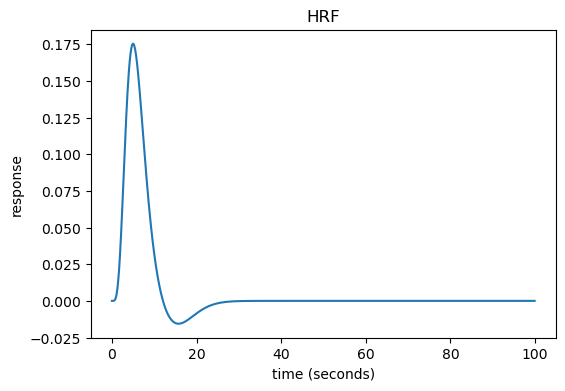

In [3]:
A = 1 # temporary (?)
%matplotlib inline

alpha1 = 6
alpha2 = 16
beta1 = 1
beta2 = 1
c = 1/6

def HRF(t, A, c, alpha1, alpha2, beta1, beta2):
    h = A*(gamma.pdf(t, alpha1, scale=1/beta1)- c*gamma.pdf(t, alpha2, scale=1/beta2))
    return h

h = HRF(t, A, c, alpha1, alpha2, beta1, beta2)

plt.figure(figsize=(6,4))
plt.plot(t, h)
plt.title('HRF')
plt.ylabel('response')
plt.xlabel('time (seconds)')

Note: per the documentation for the Gamma function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html), gamma.pdf(t, a, scale=1/b) is equivalent to $\frac{b^a x^{a-1}e^{b t}}{\Gamma(a)}$

Now we can obtain the measured BOLD response by convolving the simulated neural activation signal with the HRF: (mode='same' gives an output of same size as the first argument)

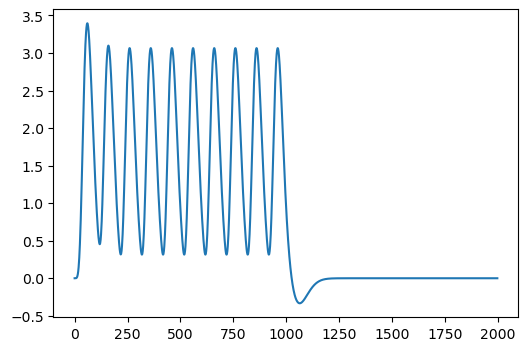

In [4]:
bold = scipy.signal.convolve(neur, h, mode='full')

plt.figure(figsize=(6,4))
plt.plot(bold)

Note that the BOLD signal is longer, and drops at the end of the measurment. For simplicity, we can crop out all parts of the signal outside of the measurement time. 

*Note that using mode="valid" on the convolution crops the output to incldue the ending*

Text(0, 0.5, 'response')

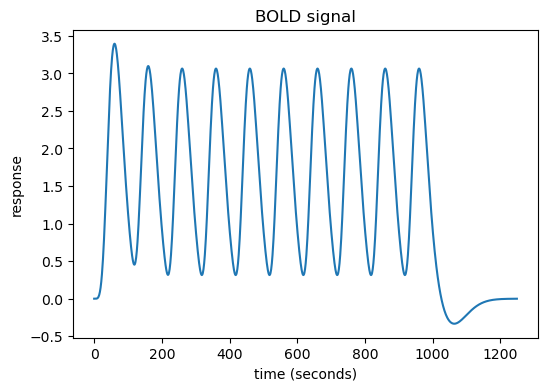

In [5]:
padding = 25 # [sec]
bold = bold[0:(total_duration+25)*Ts]

plt.figure(figsize=(6,4))
plt.plot(bold)
plt.title('BOLD signal')
plt.xlabel('time (seconds)')
plt.ylabel('response')

## 3. Observing the Effects of the alpha Parameters

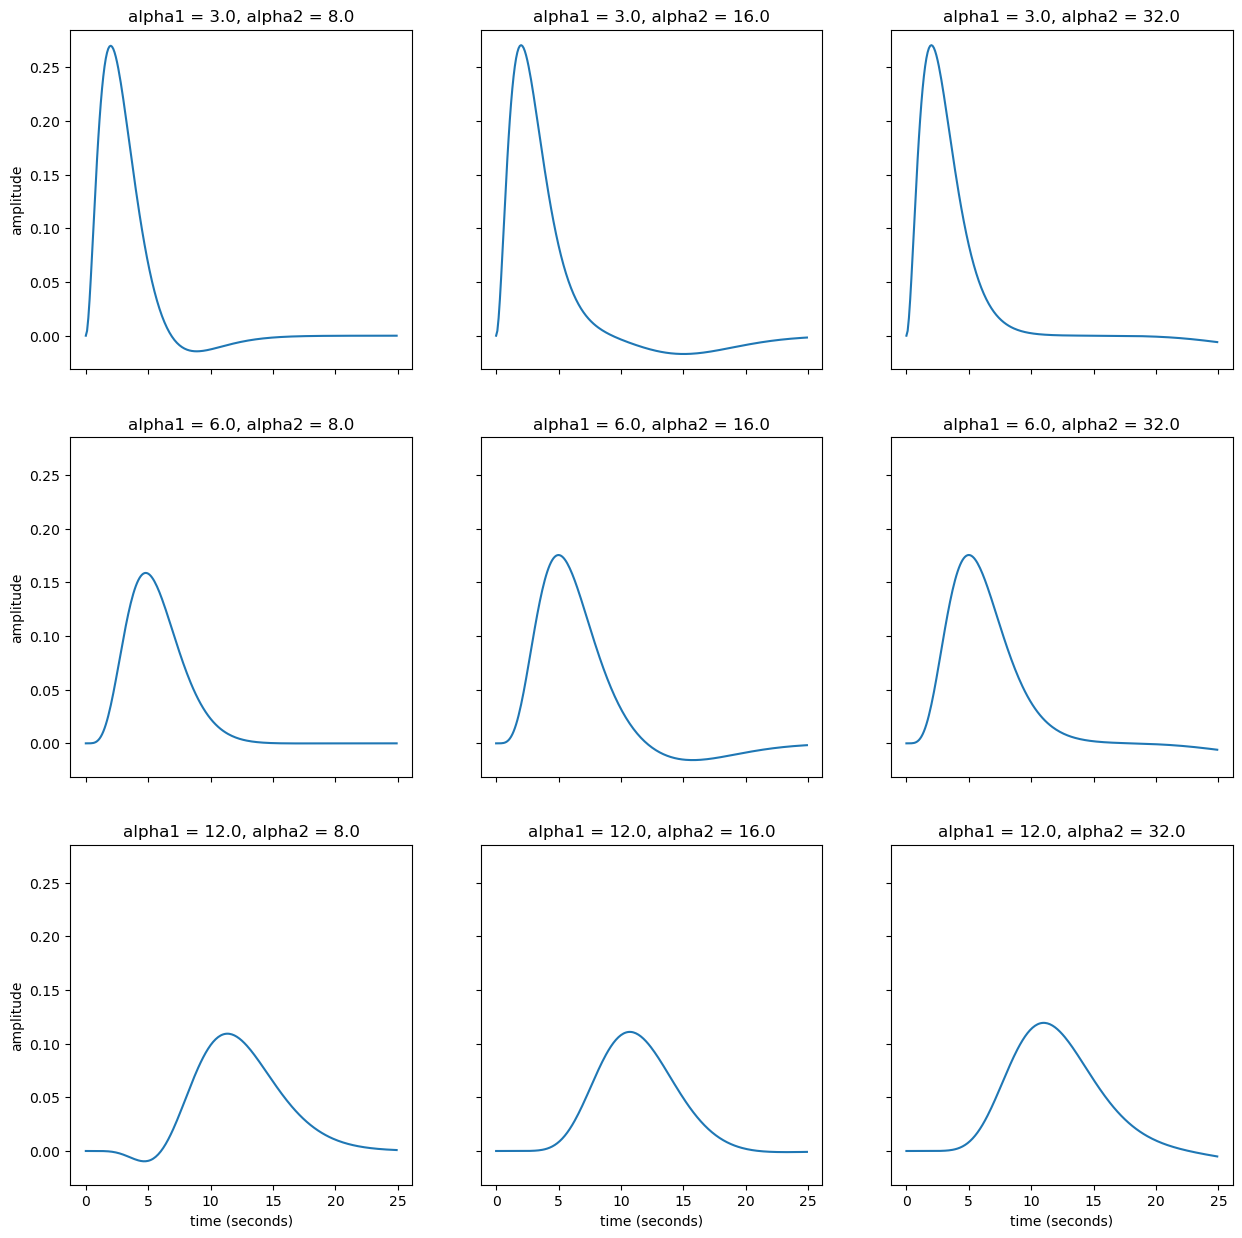

In [6]:
%matplotlib inline

alpha1s = np.array([0.5, 1, 2])*alpha1
alpha2s = np.array([0.5, 1, 2])*alpha2
t_cut = np.arange(0, 25, 1/Ts)

fig, axs = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        axs[i,j].plot(t_cut, HRF(t_cut, A, c, alpha1s[i], alpha2s[j], beta1, beta2))
        axs[i,j].set_title(f"alpha1 = {alpha1s[i]}, alpha2 = {alpha2s[j]}")
for i in range(3):
    axs[i,0].set_ylabel('amplitude')
    axs[2,i].set_xlabel('time (seconds)')

## 4. Adding Gaussian Noise ##

In [7]:
np.random.seed(0)

sigma = 0.15 # std dev of the noise added
t = np.arange(0, total_duration+25, 1/Ts)
bold_noisy = bold + np.random.normal(0, sigma, t.shape)

Text(0.5, 1.0, 'HRF With Gaussian Noise')

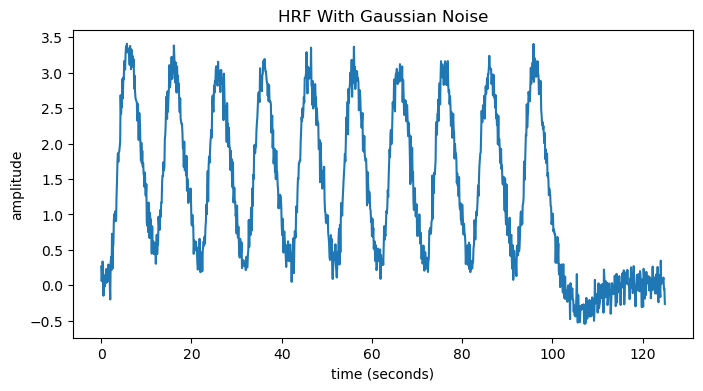

In [8]:
plt.figure(figsize=(8,4))
plt.plot(t, bold_noisy)
plt.xlabel('time (seconds)')
plt.ylabel('amplitude')
plt.title('HRF With Gaussian Noise')

## 5. Construction of the GLM ##

Construct a GLM where y is the simulated BOLD voxel time-series. Then we attempt to interpolate the neuron activation from a matrix X of basis vectors. Each column corresponds to a HRF function convolved with a Dirac at the moment of a presentation. 

In [9]:
y = bold_noisy
# active = np.array([1,0,0,0]*25)
# rest = np.array([0,1,1,1]*25)

neur_rest = -0.5*(scipy.signal.square(2*np.pi*(1/episode_duration)*t, presentation_duration/episode_duration)+1)+1
rest = scipy.signal.convolve(neur_rest, h, mode='full')

rest = rest[:(total_duration+25)*Ts]
constant = np.ones((total_duration+25)*Ts)

X = pd.DataFrame(data={'active':bold, 'rest':rest, 'constant':constant})

In [10]:
X.shape

(1250, 3)

In [11]:
X

,active,rest,constant
0,0.000000e+00,0.000000,1.0
1,7.540312e-08,0.000000,1.0
2,2.258685e-06,0.000000,1.0
3,1.726025e-05,0.000000,1.0
4,7.446090e-05,0.000000,1.0
...,...,...,...
1245,-5.533804e-04,5.987665,1.0
1246,-5.236999e-04,5.895855,1.0
1247,-4.955454e-04,5.809070,1.0
1248,-4.688424e-04,5.727741,1.0


## 6. Solving the GLM ##

Using OLS estimator; using the formula as seen in class:
$$ \bar{\beta} = (X^TX)^{-1}X^Ty $$

In [12]:
X_ = X.to_numpy()
beta = np.linalg.inv(X_.T@X_)@X_.T@y
y_hat = X_@beta

In [13]:
print(beta)

[ 0.9876255  -0.00115087  0.02115584]


Text(0, 0.5, 'amplitude')

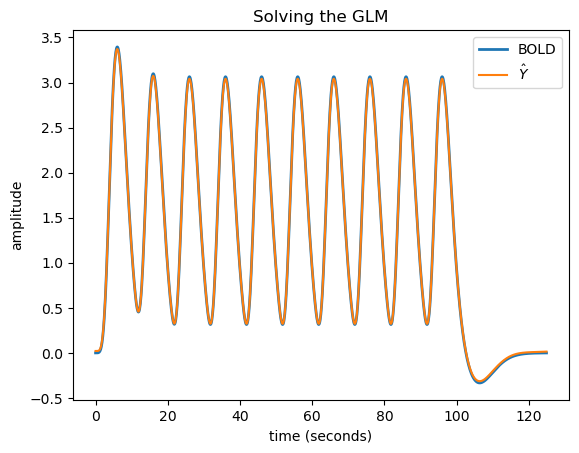

In [14]:
# plt.plot(t,y,label='Y')
plt.plot(t, bold, linewidth=2, label='BOLD')
plt.plot(t,y_hat,label='$\hat Y$')
plt.legend()
plt.title('Solving the GLM')
plt.xlabel('time (seconds)')
plt.ylabel('amplitude')

In [15]:
print(np.sum(np.abs(bold-y_hat))) # residual (error)

14.684829894772426


In [16]:
print(np.sum(np.abs(bold-y_hat))/(total_duration/10))

1.4684829894772427


*Correct to do bold and not y???*

## 7. Hypothesis Test on the Regressors ##

In [17]:
# Show if any are statistically different from zero using T-Test.
import scipy.stats as stats
# print(stats.ttest_ind(X_*beta[0],y,alternative='two-sided'))
# print(stats.ttest_ind(X_*beta[1],y,alternative='two-sided'))
# print(stats.ttest_ind(X_*beta[2],y,alternative='two-sided'))
print(stats.ttest_ind(X_*beta,y,alternative='two-sided'))

Ttest_indResult(statistic=array([ -0.30740359, -42.03811458, -41.1415613 ]), pvalue=array([7.58561819e-001, 1.55750441e-292, 5.83493129e-283]))


/var/folders/bj/jt74ftb16rjc33clq00_ylx80000gn/T/ipykernel_27526/1397333732.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(stats.ttest_ind(X_*beta,y,alternative='two-sided'))


This shows that the first regressor, corresponding to the active images, is statistically different from zero.

## 8. Graphical Representation of the Design Matrix ##

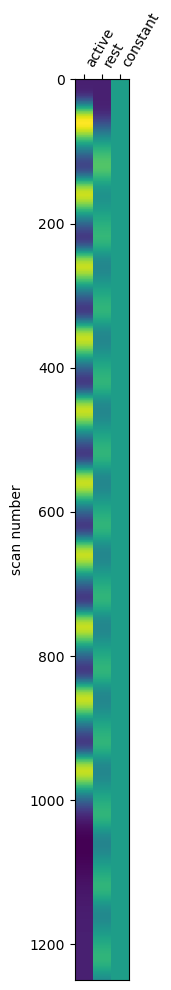

In [18]:
plot_design_matrix(X) # insert pd dataframe
plt.show()

where active = face and rest = object

## 9. Repeat for a Real Dataset (Optional) ##

In [19]:
# this is where we would find the region of the brain being activated 

# Extra: Putting it all into functions #

In [49]:
def generate_stim(faces_onset, faces_dur, ctrl_onset, ctrl_dur, trial_dur, trials, faces_A=1, ctrl_A=0.1, Ts=10, make_plot=False):
    t = np.arange(0, trial_dur*trials, 1/Ts)
    faces = faces_A*0.5*(scipy.signal.square(2*np.pi*(1/trial_dur)*t, faces_dur/trial_dur)+1)
    ctrl = 0.5*(scipy.signal.square(2*np.pi*(1/trial_dur)*t, ctrl_dur/trial_dur)+1)
    ctrl = ctrl[:ctrl.shape[0]-ctrl_onset*Ts]
    ctrl = np.concatenate((np.zeros(ctrl_onset*Ts), ctrl))
    stim = faces + ctrl_A*ctrl
    if make_plot:
        plt.figure(figsize=(9,4))
        plt.plot(t, stim)
        plt.title('Single voxel time series')
        plt.xlabel('time (seconds)')
        plt.ylabel('activation')
    return t, faces, ctrl, stim

def HRF(t, A, alpha1=6, alpha2=16, beta1=1, beta2=1, c=1/6, make_plot=False):
    h = A*(gamma.pdf(t, alpha1, scale=1/beta1)- c*gamma.pdf(t, alpha2, scale=1/beta2))
    if make_plot:
        plt.figure(figsize=(6,4))
        plt.plot(t, h)
        plt.title('HRF')
        plt.ylabel('response')
        plt.xlabel('time (seconds)')
    return h

def generate_bold(HRF_A, stim, total_dur, padding=25, Ts=10):
    t = np.arange(0, total_dur+padding, 1/Ts)
    h = HRF(t, HRF_A)
    bold = scipy.signal.convolve(stim, h, mode='full')
    bold = bold[0:(total_dur+padding)*Ts]
    return t, bold

def generate_noisy_bold(HRF_A, stim, total_dur, noise_seed, padding=25, sigma = 0.15, Ts=10):
    t = np.arange(0, total_dur+padding, 1/Ts)
    h = HRF(t, HRF_A)
    bold = scipy.signal.convolve(stim, h, mode='full')
    bold = bold[0:(total_dur+padding)*Ts]
    np.random.seed(noise_seed)
    noise = np.random.normal(0, sigma, t.shape)
    bold = bold + noise
    return t, bold

def solve_GLM(y_noisy, stim_faces, stim_ctrl, HRF_A, total_dur, Ts=10):
    X_active = generate_bold(HRF_A, stim_faces, total_dur, Ts=Ts)[1]
    X_rest = generate_bold(HRF_A, stim_ctrl, total_dur, Ts=Ts)[1]
    X_cst = np.ones_like(X_active)
    X = pd.DataFrame(data={'active':X_active, 'rest':X_rest, 'constant':X_cst})
    X_ = X.to_numpy()
    beta = np.linalg.inv(X_.T@X_)@X_.T@y_noisy
    y_hat = X_@beta
    return X, X_, beta, y_hat

def run_compute_residuals(trials=10, HRF_A=1, sigma=0.15, stim_timings = (0, 2, 5, 2, 10)):
    # Used for the theoretical parts
    # stim_timings = (face_onset, face_dur, ctrl_onset, ctrl_dur, trial_dur)
    
    (t, stim_faces, stim_ctrl, stim) = generate_stim(stim_timings[0], stim_timings[1], stim_timings[2], stim_timings[3], stim_timings[4], trials, make_plot=True)
    (t_conv, y_real) = generate_bold(HRF_A, stim, stim_timings[4]*trials)
    (t_conv, y_noisy) = generate_noisy_bold(HRF_A, stim, stim_timings[4]*trials, 0, sigma=sigma)
    (X, X_, beta, y_hat) = solve_GLM(y_noisy, stim_faces, stim_ctrl, HRF_A, stim_timings[4]*trials)
    residual = np.sum(np.abs(y_real-y_hat))
    return t_conv, X, y_real, y_noisy, y_hat, beta, residual

[0.98793636 0.09858936 0.01524053]
14.576947013249127


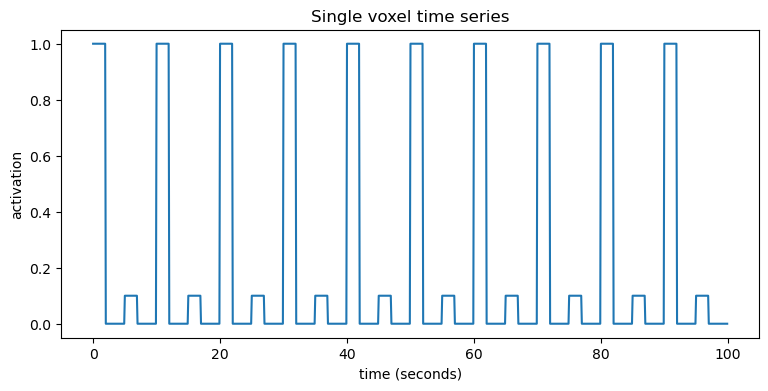

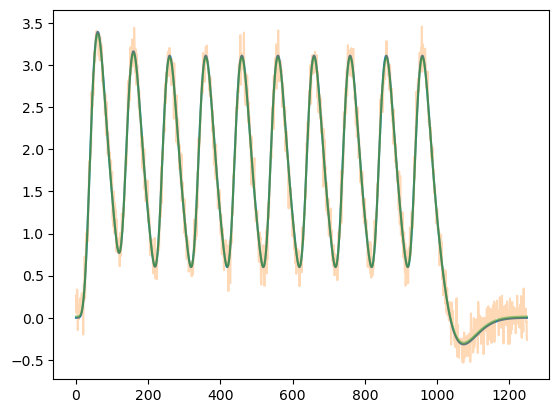

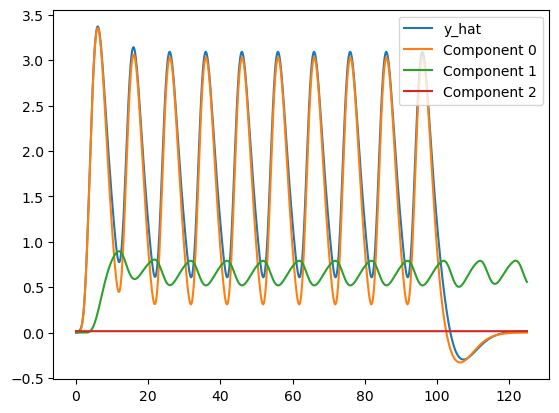

In [50]:
(t_conv, X, y_real, y_noisy, y_hat, beta, residual) = run_compute_residuals()

print(beta)
print(residual)

plt.figure()
plt.plot(y_real)
plt.plot(y_noisy, alpha=0.3)
plt.plot(y_hat, alpha=0.5)

plt.figure()
plt.plot(t_conv, y_hat, label='y_hat')
for i in range(0, X.shape[1]):
    plt.plot(t_conv, X_[:,i]*beta[i], label=f'Component {i}')
plt.legend()

For A=0.1 the residual is 14.576947013250306 and the RRE is 145.76947013250305
For A=1 the residual is 14.576947013249171 and the RRE is 14.576947013249171
For A=10 the residual is 14.576947013269352 and the RRE is 1.4576947013269352
For sigma=0.01 the residual is 0.9717964675491687
For sigma=0.1 the residual is 9.717964675499104
For sigma=10 the residual is 971.7964675500099
For trials=1 the RRE is 6.8333042672895115
For trials=10 the RRE is 1.457694701324917
For trials=100 the RRE is 0.27643425925148835


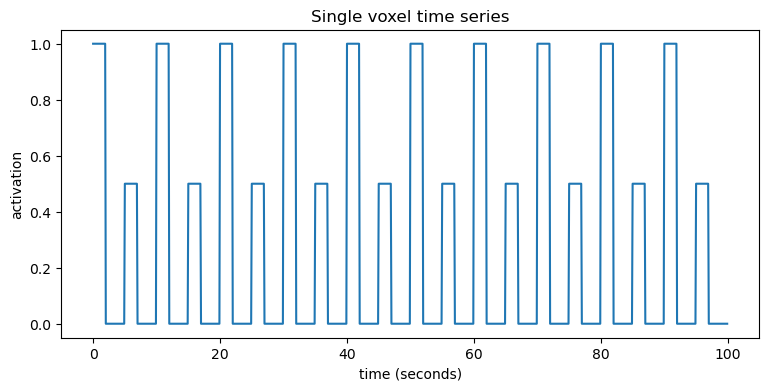

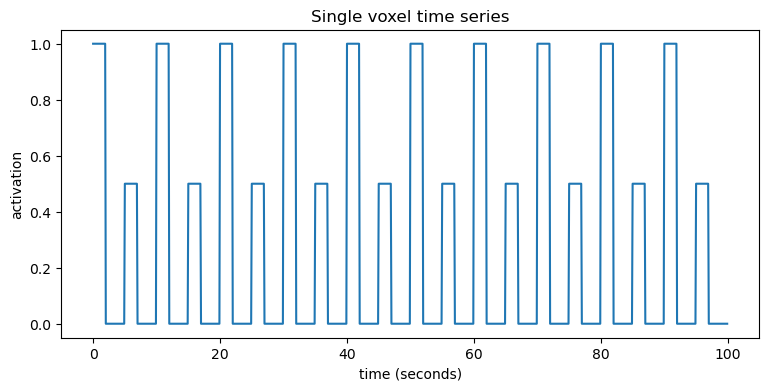

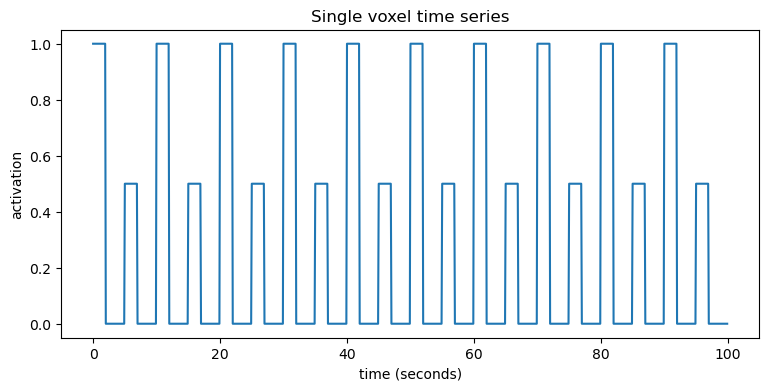

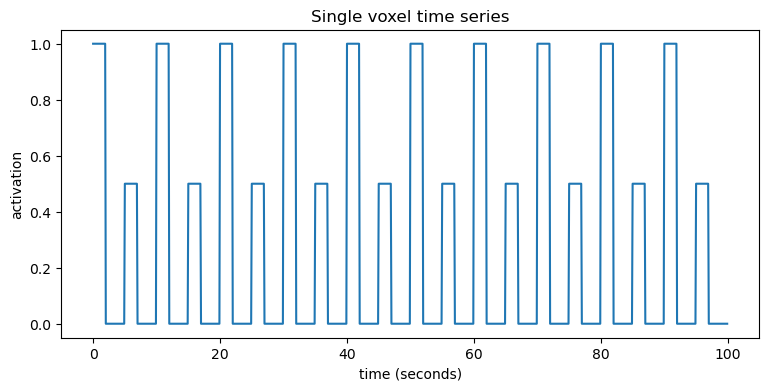

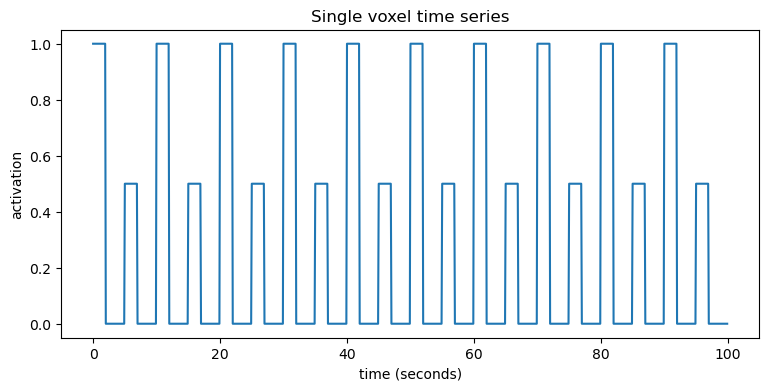

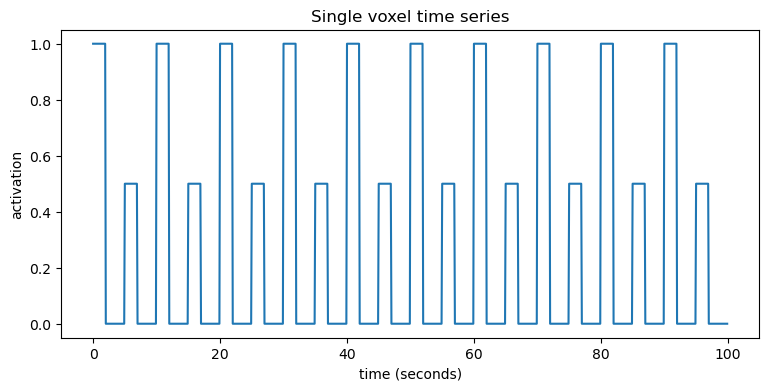

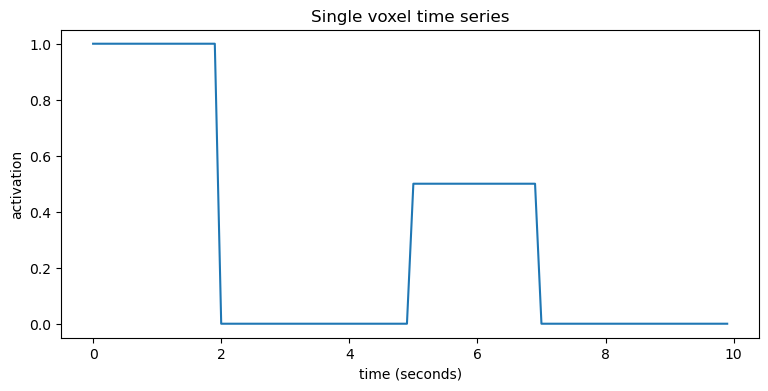

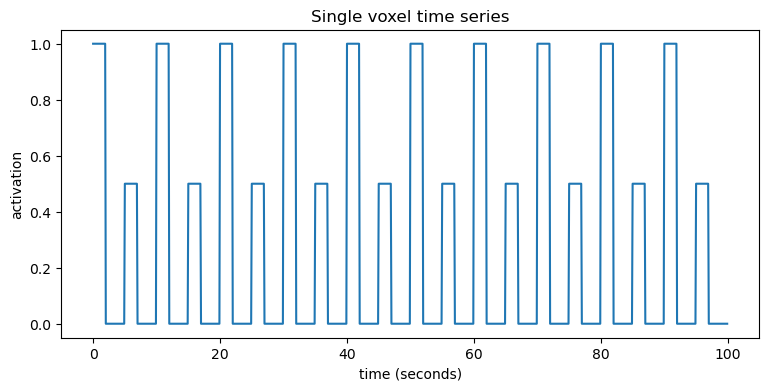

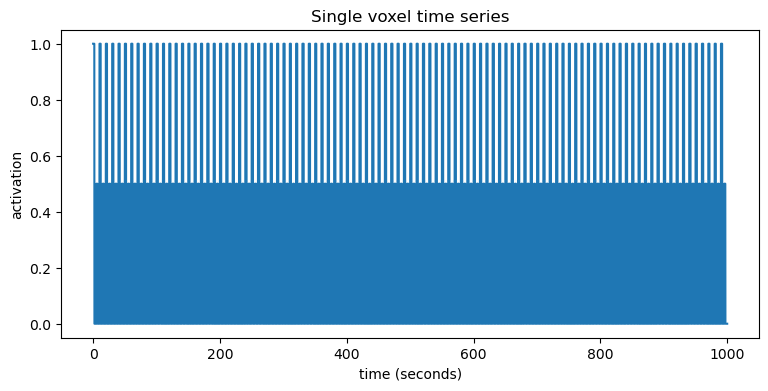

In [48]:
As = (0.1, 1, 10)
sigmas = (0.01, 0.1, 10)
trialses = (1, 10, 100)

for A in As:
    (t_conv, X, y_real, y_noisy, y_hat, beta, residual) = run_compute_residuals(HRF_A=A)
    print(f'For A={A} the residual is {residual} and the RRE is {residual/A}')
for sigma in sigmas:
    (t_conv, X, y_real, y_noisy, y_hat, beta, residual) = run_compute_residuals(sigma=sigma)
    print(f'For sigma={sigma} the residual is {residual}')
for trials in trialses:
    (t_conv, X, y_real, y_noisy, y_hat, beta, residual) = run_compute_residuals(trials=trials)
    print(f'For trials={trials} the RRE is {residual/trials}')